In [1]:
#libraries/Packages versions used for this Project
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
appdirs                       1.4.4          
argon2-cffi                   20.1.0         
asgiref                       3.3.1          
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.3.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.9.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.3.

In [2]:
#Installing main libaries used in this project
!pip install -U scikit-learn
!pip install matplotlib
!pip install sklearn
!pip install shap
!pip install joblib
!pip install pdpbox
import xgboost
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('max_columns', 40)

     |████████████████████████████████| 22.2MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 358kB 11.6MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489393 sha256=086478f0b780fac07b46d03ed6a7a6898032d9071ff5fb29b899321ca82e3699
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
     |████████████████████████████████| 57.7MB 78kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=418d37dce2209e184be17030bd77f7c2180a37ae3f2a3faa9ca2e16a79ebb966
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [3]:
#importing data
import pandas as pd
df = pd.read_csv("https://github.com/JonRivera/Hotel_Check_Out_Project/blob/master/Data/hotel_bookings.csv?raw=true")

## EXPLORATORY ANALYSIS 


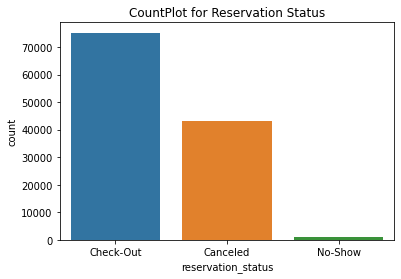

In [ ]:
target = 'reservation_status'
sns.countplot(df['reservation_status'])
plt.title('CountPlot for Reservation Status');

In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## WRANGLE DATA

In [ ]:
def wrangle(df):
    df = df.copy()
    #drop unecessary columns, or columns that seem to have little impact on target
    df = df.drop(['company', 'agent','arrival_date_week_number'],axis = 1)
    df = df.dropna(axis=0)  
    
    #set date column to index
    #doesn't add any substantial info, and has high cardinality. 
    df.set_index(pd.to_datetime(df['reservation_status_date']), inplace = True)
    df = df.drop(['reservation_status_date'], axis=1)
    
    
    #I am treating cancelations as people who canceled or did not show
    #on there arrival date --- it was assumend the hotel would treat 
    df['reservation_status'] =  df['reservation_status'].replace({'No-Show':'Canceled'})
    
    #features selected based on feature imporances
    features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations',
                'booking_changes', 'adr', 'required_car_parking_spaces', 'country', 'deposit_type']
    return df,features
df,features = wrangle(df)


## TRAIN, VALIDATE, TEST SPLIT


In [ ]:
#get train, validate,and test subsets
train = df[df['arrival_date_year']==2015].copy()
val = df[df['arrival_date_year']==2016].copy()
test = df[df['arrival_date_year'] == 2017].copy()
train.shape, val.shape, test.shape

((21859, 28), (56435, 28), (40604, 28))

In [ ]:
#seperating X matrices and correspind y vectors
target = 'reservation_status'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val= val[features]
y_val = val[target]
X_train.shape,y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape

((21859, 9), (21859,), (56435, 9), (56435,), (40604, 9), (40604,))

## BASELINE

In [ ]:
#baselines
#Training Baseline
y_train.value_counts(normalize=True)


Check-Out    0.629169
Canceled     0.370831
Name: reservation_status, dtype: float64

In [ ]:
#Validation Baseline
y_val.value_counts(normalize=True)


Check-Out    0.640064
Canceled     0.359936
Name: reservation_status, dtype: float64

In [ ]:
#instantitate classes

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import category_encoders as ce
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

## Model0- Random Tree Forest Classifier

In [ ]:
#Build pipeline using RadnomSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
model0 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs = -1, random_state=40)

)

param_distributions = { 
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': [5,10,20],
    'randomforestclassifier__min_samples_split': [5,10,15,20],
    'randomforestclassifier__min_samples_leaf': [2]
}
search = RandomizedSearchCV(
    model0, 
    param_distributions = param_distributions,
    n_iter = 10,
    cv=10,
    scoring ='accuracy',
    verbose = 1,
    return_train_score = True,
    n_jobs = -1
)

search.fit(X_train, y_train)
print('Cross-validation Best Score', search.best_score_)
print('Best Estimator:' ,search.best_params_)
print('Best Model', search.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished


Cross-validation Best Score 0.8383316968183216
Best Estimator: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 15, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__criterion': 'entropy'}
Best Model Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'deposit_type'],
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': PRT     1
GBR     2
USA     3
ESP     4
IRL     5
       ..
GEO    95
TMP    96
MUS    97
ECU    98
NaN    -2
Length: 99, dtype: int64},
                                         {'col': 'deposit_type',
                                          'data_type': dtype('O'),
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64}])),
        

In [ ]:
model0 = search.best_estimator_
model0

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'deposit_type'],
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': PRT     1
GBR     2
USA     3
ESP     4
IRL     5
       ..
GEO    95
TMP    96
MUS    97
ECU    98
NaN    -2
Length: 99, dtype: int64},
                                         {'col': 'deposit_type',
                                          'data_type': dtype('O'),
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_features=5,
                                        min_samples_leaf=2,
                                        min_samples_split=15, n_jobs=-1,
          

In [ ]:
y_pred0 = model0.predict(X_val)
y_pred_probab0 = model0.predict_proba(X_val)

In [ ]:
print('Random Forest Classifier Classification Report')
print(classification_report(y_val, y_pred0))

Random Forest Classifier Classification Report
              precision    recall  f1-score   support

    Canceled       0.85      0.45      0.59     20313
   Check-Out       0.76      0.96      0.84     36122

    accuracy                           0.77     56435
   macro avg       0.80      0.70      0.72     56435
weighted avg       0.79      0.77      0.75     56435



In [ ]:
roc_auc_score(y_val,y_pred_probab0[:,1])

0.7540128331242869

In [ ]:
accuracy_score(y_val,y_pred0)

0.7734207495348632

## Model1 - XGBOOST 

Run XGBoost w/ Early Stopping to prevent overfitting and optimize n_estimators.

In [ ]:
from xgboost.sklearn import XGBClassifier
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)
model1 = XGBClassifier(
        n_estimators = 20, 
        max_depth = 5,
        learning_rate = .5,
        n_jobs = -1

)


model1.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluation Metrics


In [ ]:
#Helps me identify the order of the class labels in the target
model1.classes_ 

array(['Canceled', 'Check-Out'], dtype=object)

In [ ]:
y_pred1 = model1.predict(X_val_encoded)
y_pred_probab1 = model1.predict_proba(X_val_encoded)

In [ ]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

    Canceled       0.88      0.43      0.57     20313
   Check-Out       0.75      0.97      0.84     36122

    accuracy                           0.77     56435
   macro avg       0.81      0.70      0.71     56435
weighted avg       0.79      0.77      0.75     56435



In [ ]:
roc_auc_score(y_val,y_pred_probab1[:,1])

0.7782593775553881

In [ ]:
accuracy_score(y_val,y_pred1)

0.7716842385044742


## Model2 - Logistic Regression

In [ ]:
#Improved logistic regression model by hyperparameter tunning
#Max iterations
model2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LogisticRegression(random_state=40, max_iter = 200)
)
model2.fit(X_train, y_train)



Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'deposit_type'],
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': PRT     1
GBR     2
USA     3
ESP     4
IRL     5
       ..
GEO    95
TMP    96
MUS    97
ECU    98
NaN    -2
Length: 99, dtype: int64},
                                         {'col': 'deposit_type',
                                          'data_type': dtype('O'),
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression',
                 LogisticRegression(max_iter=200, random_state=40))])

## ROCAUC Curve for Model 0, Model1,Model2

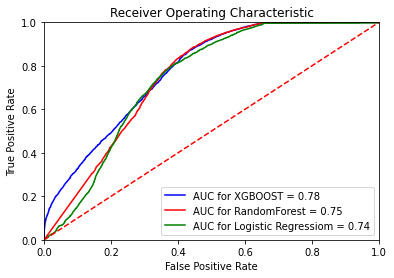

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

probs2 = model2.predict_proba(X_val)
preds2 = probs2[:,1]
fpr2,tpr2, threshold = metrics.roc_curve(y_val,preds2, pos_label='Check-Out')
roc_auc2 = metrics.auc(fpr2,tpr2)

probs1 = model1.predict_proba(X_val_encoded)
preds1 = probs1[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_val, preds1, pos_label='Check-Out')
roc_auc1 = metrics.auc(fpr1, tpr1)

probs0 = model0.predict_proba(X_val)
preds0 = probs0[:,1]
fpr0, tpr0, threshold = metrics.roc_curve(y_val, preds0, pos_label ='Check-Out')
roc_auc0 = metrics.auc(fpr0, tpr0)



# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC for XGBOOST = %0.2f' % roc_auc1)
plt.plot(fpr0, tpr0, 'r', label = 'AUC for RandomForest = %0.2f' % roc_auc0)
plt.plot(fpr2, tpr2, 'g', label = 'AUC for Logistic Regressiom = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Test Results

In [ ]:
#Compute test scores for all three models
y_pred3 = model1.predict(X_test_encoded)
print('Classification report for XGBoost on Test Set Data')
print(classification_report(y_test, y_pred3))

Classification report for XGBoost on Test Set Data
              precision    recall  f1-score   support

    Canceled       0.90      0.33      0.48     15734
   Check-Out       0.70      0.98      0.81     24870

    accuracy                           0.72     40604
   macro avg       0.80      0.65      0.65     40604
weighted avg       0.77      0.72      0.68     40604



In [ ]:
y_pred4 = model2.predict(X_test)
print('Classification Report for Logistic Regression Model on Test Set Data')
print(classification_report(y_test,y_pred4))

Classification Report for Logistic Regression Model on Test Set Data
              precision    recall  f1-score   support

    Canceled       0.94      0.27      0.42     15734
   Check-Out       0.68      0.99      0.81     24870

    accuracy                           0.71     40604
   macro avg       0.81      0.63      0.62     40604
weighted avg       0.78      0.71      0.66     40604



In [ ]:
y_pred5 = model0.predict(X_test)
print('Random Forest Classifier Classification Report on Test Set Data')
print(classification_report(y_test, y_pred5))

Random Forest Classifier Classification Report on Test Set Data
              precision    recall  f1-score   support

    Canceled       0.87      0.35      0.50     15734
   Check-Out       0.70      0.97      0.81     24870

    accuracy                           0.73     40604
   macro avg       0.79      0.66      0.65     40604
weighted avg       0.77      0.73      0.69     40604



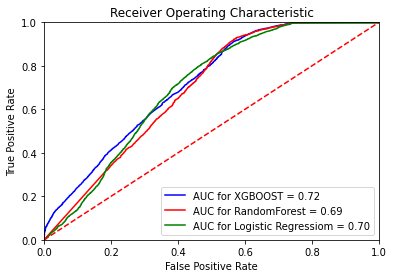

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification models
# This aucroc curve will use the test set

probs2 = model2.predict_proba(X_test)
preds2 = probs2[:,1]
fpr2,tpr2, threshold = metrics.roc_curve(y_test,preds2, pos_label='Check-Out')
roc_auc2 = metrics.auc(fpr2,tpr2)

probs1 = model1.predict_proba(X_test_encoded)
preds1 = probs1[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_test, preds1, pos_label='Check-Out')
roc_auc1 = metrics.auc(fpr1, tpr1)

probs0 = model0.predict_proba(X_test)
preds0 = probs0[:,1]
fpr0, tpr0, threshold = metrics.roc_curve(y_test, preds0, pos_label ='Check-Out')
roc_auc0 = metrics.auc(fpr0, tpr0)



# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC for XGBOOST = %0.2f' % roc_auc1)
plt.plot(fpr0, tpr0, 'r', label = 'AUC for RandomForest = %0.2f' % roc_auc0)
plt.plot(fpr2, tpr2, 'g', label = 'AUC for Logistic Regressiom = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Plotly Dash App Steps

In [ ]:

import joblib
from joblib import dump

In [ ]:
#Check Versions libary versions used
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

In [ ]:
#Checking memory size of pipeline
!ls -lh model3.joblib

In [ ]:
#Checking xgboost format
model1

In [ ]:
#Plug model1 into make_pipeline and fit it to orginal X_train,y_train
#Otherwise I encounter difficulties with dashapp
#Dash app uses scikitlearn pipline format
#Model3 is the same as model1, it's just in make_pipeline format
#Encoding happens inside the pipeline as well
model3 = make_pipeline(ce.OrdinalEncoder(),model1)
model3

In [ ]:
#Originally I was working with my xgboost for my dash app, however
#When I upload to heroku, I get problems with xgboost
#I change from model3 to model0 so things ran smoothly in heroku
#Xgboost works locally though
dump(model0, 'model0.joblib', compress=True)

In [ ]:
X_train['deposit_type'].value_counts()

In [ ]:
#Creating function for dash app
def predict(lead_time,stays_in_weekend_nights,stays_in_week_nights,
               previous_cancellations,booking_changes,adr,required_car_parking_spaces,country,deposit_type):
    df = pd.DataFrame(
        columns= ['lead_time','stays_in_weekend_nights','stays_in_week_nights',
                  'previous_cancellations','booking_changes','adr','required_car_parking_spaces',
                  'country','deposit_type']
            
            ,
        data=[[lead_time,stays_in_weekend_nights,stays_in_week_nights,
               previous_cancellations,booking_changes,adr,required_car_parking_spaces,country,deposit_type]]
    )
    y_pred_probab0 = round(model0.predict_proba(df)[0][0],2)
    y_pred = model0.predict(df)[0]
    print(f' Probabillity that person checked-out {y_pred_probab0}%')
    return f'Person {y_pred} Booking.'


In [ ]:
#Testing predict function
predict(7,20,20,0,2,10,0,'USA','Non Refund')

In [ ]:
#Checking versions of main libraries used
#Helps me create the proper virtual environment for my dashly app to run on
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')


In [ ]:
#creating features for dashly app
country_names = list(df['country'].value_counts().index)
column2 = pd.Series(country_names)
df2.columns = ['label','value']
df2.to_dict('records')
#These list of dicitionaries will be used to make an interactive feature in the plotly dash app